## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

In [3]:
train_data['purchase']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
84504    0
84505    0
84506    0
84507    0
84508    0
84509    0
84510    0
84511    0
84512    0
84513    0
84514    0
84515    0
84516    0
84517    0
84518    0
84519    0
84520    0
84521    0
84522    0
84523    0
84524    0
84525    0
84526    0
84527    0
84528    0
84529    0
84530    0
84531    0
84532    0
84533    0
Name: purchase, Length: 84534, dtype: int64

In [4]:
train_data['Promotion']

0         No
1         No
2         No
3         No
4        Yes
5         No
6         No
7         No
8        Yes
9         No
10       Yes
11        No
12       Yes
13        No
14       Yes
15        No
16       Yes
17        No
18       Yes
19       Yes
20        No
21       Yes
22        No
23        No
24        No
25       Yes
26        No
27       Yes
28        No
29        No
        ... 
84504     No
84505    Yes
84506    Yes
84507    Yes
84508    Yes
84509     No
84510     No
84511    Yes
84512     No
84513    Yes
84514    Yes
84515     No
84516    Yes
84517    Yes
84518     No
84519     No
84520     No
84521     No
84522     No
84523    Yes
84524     No
84525    Yes
84526    Yes
84527    Yes
84528     No
84529     No
84530    Yes
84531     No
84532     No
84533     No
Name: Promotion, Length: 84534, dtype: object

In [5]:
n_control = train_data.groupby('Promotion').size()['No']
n_exper = train_data.groupby('Promotion').size()['Yes']
n_exper
n_control

42170

In [6]:
n_exper_purchase = train_data.query("Promotion == 'Yes' and purchase != '0'").count()
n_exper_purchase

ID           721
Promotion    721
purchase     721
V1           721
V2           721
V3           721
V4           721
V5           721
V6           721
V7           721
dtype: int64

In [7]:
n_control_purchase = train_data.query("Promotion == 'No' and purchase != '0'").count()
n_control_purchase

ID           319
Promotion    319
purchase     319
V1           319
V2           319
V3           319
V4           319
V5           319
V6           319
V7           319
dtype: int64

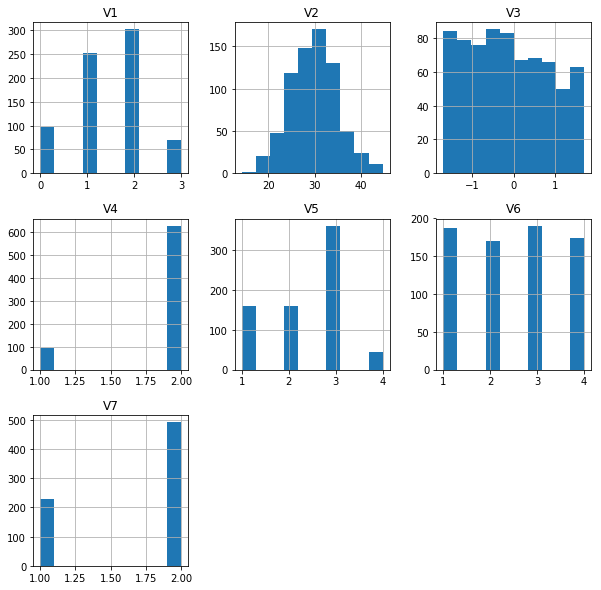

In [8]:
#Lets see what some of the data looks like:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10));

V1 and V2, looks like it has a normal distribution.  V4 looks like it contains the most data.

# Pre-test 

In [9]:
# calculate the Incremental Response Rate (IRR)
irr_rate = (n_exper_purchase/n_exper) - (n_control_purchase)/n_control
irr_rate

ID           0.009455
Promotion    0.009455
purchase     0.009455
V1           0.009455
V2           0.009455
V3           0.009455
V4           0.009455
V5           0.009455
V6           0.009455
V7           0.009455
dtype: float64

In [10]:
# calculate the Net Incremental Revenue (NIR)
nir_rate = (10 * n_exper_purchase - 0.15 * n_exper) - 10 * n_control_purchase
nir_rate

ID          -2334.6
Promotion   -2334.6
purchase    -2334.6
V1          -2334.6
V2          -2334.6
V3          -2334.6
V4          -2334.6
V5          -2334.6
V6          -2334.6
V7          -2334.6
dtype: float64

A NIR rate of -2334.6 is concerning.  This did not do very well.

# Test 1

In [11]:
def promotion_strategy_1(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion
    

In [12]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy_1)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0095931582782501079, -1132.1999999999998)

# Test 2

Lets change some of the parameters with machine learning.

In [13]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response


In [14]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0.0


In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_data, test_size=0.33, random_state=42)


In [16]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [17]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_test = test['response']
X_test = test[features]

In [18]:
# up sample only the train dataset with SMOTE
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
classifier.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [19]:
print(classifier.feature_importances_)

[ 0.03775957  0.72173819  0.15996953  0.00459461  0.02113615  0.04078516
  0.01401679]


Feature ranking:
1. feature 1 (0.721738)
2. feature 2 (0.159970)
3. feature 5 (0.040785)
4. feature 0 (0.037760)
5. feature 4 (0.021136)
6. feature 6 (0.014017)
7. feature 3 (0.004595)


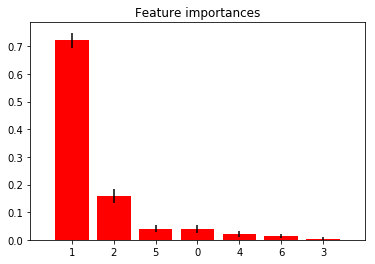

In [20]:
# Build a forest and compute the feature importances


importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Feature 1 (V1) has a signifant higher importance in this test.  We will see how it will do below.

In [21]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    test = df
    
    preds = classifier.predict(X_test)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    
    return promotion
    
    

In [22]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.1429.

Your nir with this strategy is 8.95.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.14285714285714285, 8.9499999999999993)

The second test preformed better.  It had an IRR of 0.0188 and an NIR of 8.95.  Much better than an IRR 0.0096 of and and NIR of -1132.20 from test one.  The second NIR is positive which means the altered test did not lose money on sending the promotion.  However, the results are still lower than an NIR of 189.45, which the creater of this test got.
